In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
import sys
pd.set_option('display.max_columns', None)


In [2]:
root_dir = os.path.abspath(os.path.join(os.path.dirname('see_all_expewriments.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [3]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [4]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [5]:
def calculate_avg_returns_perc(orders):
    orders_per_month = orders[['close_time','profit', 'comment']].copy()
    orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
    orders_per_month['year'] = orders_per_month['close_time'].dt.year
    orders_per_month['month'] = orders_per_month['close_time'].dt.month
    
    orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
        profit_sum=('profit', 'sum'),
    ).reset_index()
    
    orders_per_month_gb = pd.concat([
        pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
        orders_per_month_gb
    ])
    
    orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()
    
    orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))
    
    return orders_per_month_gb.perc_change.mean(), orders_per_month_gb.perc_change.std()

In [6]:
with open('configs/parameters.yml', 'r') as archivo:
    parameters = yaml.safe_load(archivo)

In [7]:
eta = 0
for param, value in parameters.items():
    if eta == 0:
        eta += len(value)
    else:
        eta *= len(value)

eta = (eta * 10) / 60

print(f'el tiempo estimado de los experimentos es de {round(eta, 2)} horas')

el tiempo estimado de los experimentos es de 3.0 horas


In [8]:
# with open('configs/project_config.yml', 'r') as archivo:
#     config = yaml.safe_load(archivo)
# tickers = config["tickers"] 
# tickers

In [9]:
results_dict = {}
initial_wallet_value = 1000
from pathlib import Path

# iteration = '3'
# experiments_path = f'./backbone/data/backtest/experiments/{iteration}'
# paths = sorted(Path(experiments_path).iterdir(), key=os.path.getmtime)
# paths = [p.__str__().split('\\')[-1] for p in paths]


paths = os.listdir('./backbone/data/backtest/experiments')
experiments_path = f'./backbone/data/backtest/experiments'

# paths = [
#     '0/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_True_opt',
#     '0/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseTime_True-TS_False_opt',
#     '1/Mode_train-Model_gradient_boosting-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseTime_True-TS_True_opt',
#     '2/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_True_opt',
#     '4/Mode_train-Model_None-TrainWw_11520-TrainPd_24-TradStgy_only_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_False_opt'
# ]

for path in paths:
    if not path.endswith('.csv'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join(experiments_path, path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join(experiments_path, path, 'orders.csv'))
    
            mean_returns, std_returns = calculate_avg_returns_perc(orders)
            results_dict[path]['mean_perc_returns'] = mean_returns
            results_dict[path]['std_perc_returns'] = std_returns
            
            
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            # avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            # results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 
    
            
            # Asegurarse de que la columna 'Date' esté en formato de fecha
            orders['date'] = pd.to_datetime(orders['close_time'])
            orders['date_rounded'] = orders['date'].dt.floor('D')
            daily_profits = orders.groupby('date_rounded')['profit'].sum()
            daily_returns = daily_profits.pct_change()
            tasa_libre_riesgo_anual = 0.02
            tasa_libre_riesgo_diaria = (1 + tasa_libre_riesgo_anual) ** (1/252) - 1
            exceso_retorno = daily_returns - tasa_libre_riesgo_diaria
            sharpe_ratio_anualizado = (exceso_retorno.mean() / exceso_retorno.std()) * np.sqrt(252)
    
            results_dict[path]['sharpe_ratio'] = sharpe_ratio_anualizado
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())
    
            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()
    
            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        try:
            train_results = pd.read_csv(os.path.join(experiments_path, path, 'trainres.csv')).dropna()
            results_dict[path]['avg_train_precision'] = train_results['precision'].mean()
            results_dict[path]['avg_train_recall'] = train_results['recall'].mean()
            results_dict[path]['avg_train_f1'] = train_results['f1'].mean()
        except:
            results_dict[path]['avg_train_precision'] = 0
            results_dict[path]['avg_train_recall'] = 0
            results_dict[path]['avg_train_f1'] = 0
            
        try:
            predictions = pd.read_csv(os.path.join(experiments_path, path, 'test_res.csv')).dropna()
    
            results_dict[path]['avg_test_precision'] = precision_score(predictions.y_true, predictions.y_pred, average='weighted')
            results_dict[path]['avg_test_recall'] = recall_score(predictions.y_true, predictions.y_pred, average='weighted')
            results_dict[path]['avg_test_f1'] = f1_score(predictions.y_true, predictions.y_pred, average='weighted')
        except:
            results_dict[path]['avg_test_precision'] = 0
            results_dict[path]['avg_test_recall'] = 0
            results_dict[path]['avg_test_f1'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

TStgy_ConsecutiveCandles-PerFwTg_24-SL_100-RR_0.1-INT_2-TTIR_1-Lv_200-RP_1
TStgy_ConsecutiveCandles-PerFwTg_24-SL_100-RR_0.2-INT_2-TTIR_1-Lv_200-RP_1
TStgy_ConsecutiveCandles-PerFwTg_24-SL_100-RR_0.5-INT_2-TTIR_1-Lv_200-RP_1
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_1
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_10
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_4
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_5
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.2-INT_2-TTIR_1-Lv_200-RP_15
TStgy_ConsecutiveCandles-PerFwTg_24-SL_60-RR_0.2-INT_2-TTIR_1-Lv_200-RP_15
TStgy_ConsecutiveCandlesV2-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_1
TStgy_ConsecutiveCandlesV2-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15
TStgy_ConsecutiveCandlesV2-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_5
TStgy_ConsecutiveCandles

In [10]:
# beta = 0.05
# eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
# results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
# results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [11]:
positive_results = results[
    [
        # 'operation_ratio_2',
        'operation_ratio', 
        # 'buy_ratio',
        # 'mean_perc_returns',
        # 'std_perc_returns',
        # 'winning_rate',
        # 'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        # 'profits_in_EURUSD',
        # 'profits_in_GBPUSD', 
        # # 'profits_in_USDJPY', 
        # 'profits_in_USDCAD',
        # 'profits_in_AUDUSD', 
        # 'profits_in_USDCHF',
        # 'avg_train_precision',
        # 'avg_train_recall',
        # 'avg_train_f1',
        # 'avg_test_precision',
        # 'avg_test_recall',
        # 'avg_test_f1',
    ]
]

positive_results = positive_results.sort_values(by=['wallet', 'sharpe_ratio', 'max_drawdown'], ascending=[False, False, True])

positive_results.head(50)

,operation_ratio,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15_old,0,-0.242781,14.535244,0.595290,0,0,390.100156
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15,0,-3.478970,5.751662,0.389256,0,0,218.250568
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_100-RR_0.2-INT_2-TTIR_1-Lv_200-RP_5,0,-5.704749,12.453712,0.310331,0,0,182.771275
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_100-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15,0,-2.674434,15.602780,0.547742,0,0,121.960323
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_15,0,-3.493035,4.256367,0.162233,0,0,106.299161
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_100-RR_0.1-INT_2-TTIR_1-Lv_200-RP_5,0,-3.495511,17.750463,0.397980,0,0,85.755563
TStgy_ConsecutiveCandles-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_10,0,-3.542224,4.160793,0.105321,0,0,64.708402
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_50-RR_0.2-INT_2-TTIR_1-Lv_200-RP_1,0,0.328467,10.351018,0.151540,0,0,60.635626
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_50-RR_0.1-INT_2-TTIR_1-Lv_200-RP_5,0,-2.976292,26.867061,0.396734,0,0,52.502446
TStgy_ConsecutiveCandlesV4-PerFwTg_24-SL_100-RR_0.1-INT_2-TTIR_1-Lv_200-RP_1,0,-1.721526,7.738847,0.110538,0,0,40.459596


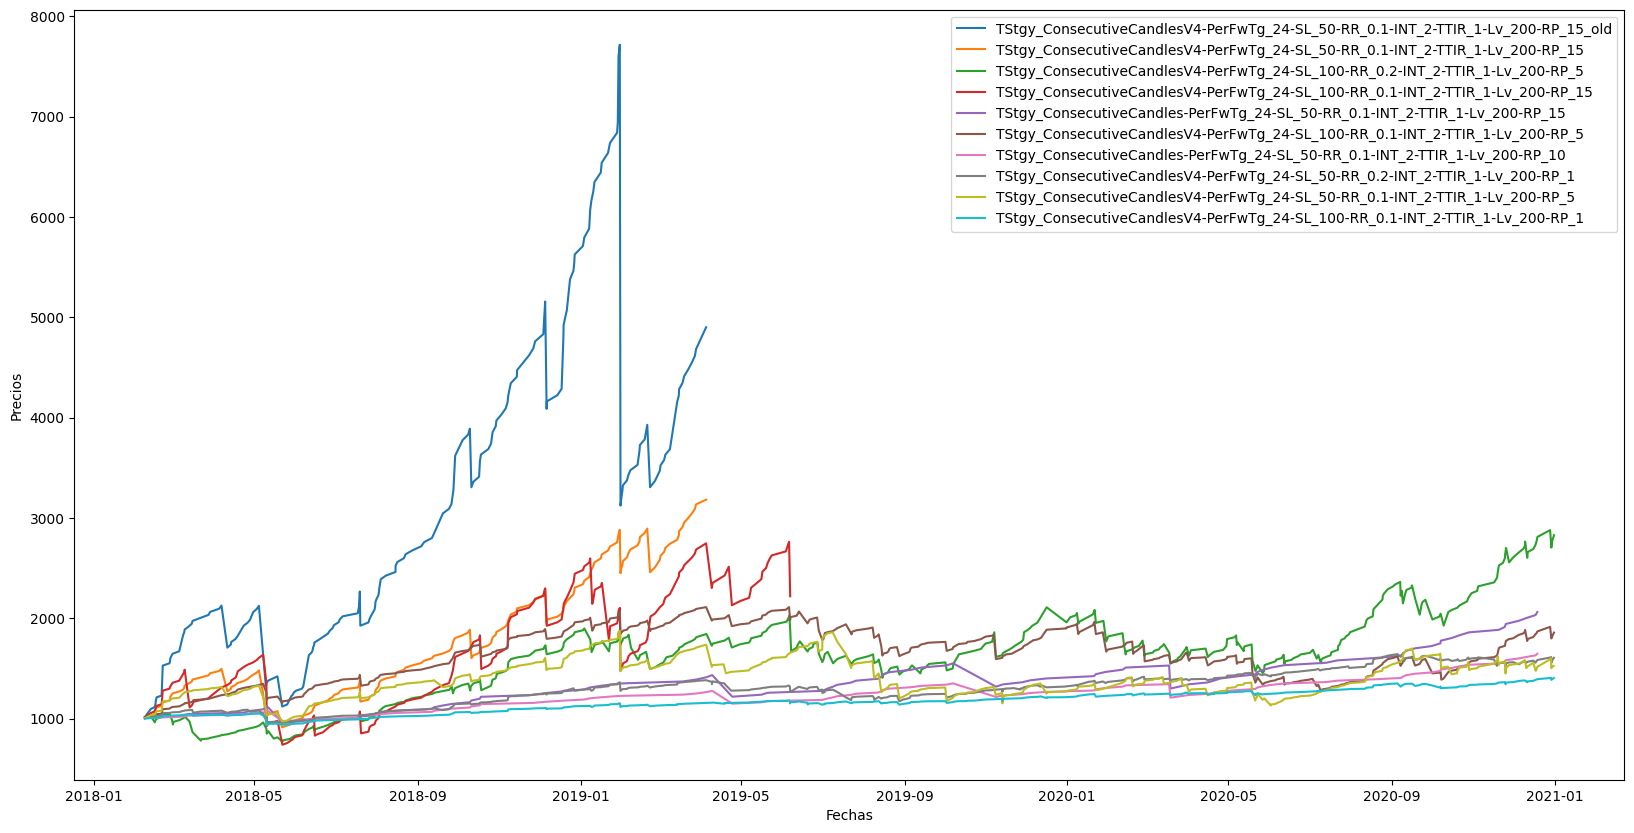

In [12]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results.sort_values(by='wallet', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(20, 10))
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join(experiments_path, path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label=f'{path}')
    
# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()
    
    # Mostrar el gráfico
    # print(path)
plt.show()
    # time.sleep(5)
    # clear_output(wait=True)

In [13]:
import re

In [14]:
filter_results = results[results['wallet']>0]


In [15]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [16]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PerFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
filter_results['trailing_stop'] = filter_results['experiment'].apply(lambda x: x.split('TS_')[1])
# filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
filter_results[
    (filter_results.model=='gradient_boosting')
    &(filter_results.strategy=='bband_sell_stgy')
    &(filter_results.sl=='10')
    &(filter_results.periods_forward_target=='12')
    &(filter_results.trailing_stop=='True')
]

In [ ]:
'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_False'


In [ ]:
print(filter_results['strategy'].value_counts())
print('-----------------------------------------')
print(filter_results['model'].value_counts())
print('-----------------------------------------')
print(filter_results['window'].value_counts())
print('-----------------------------------------')
print(filter_results['rr'].value_counts())
print('-----------------------------------------')
print(filter_results['sl'].value_counts())
print('-----------------------------------------')
print(filter_results['periods_forward_target'].value_counts())

In [ ]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio', 'mean'), ascending=False).dropna().round(4)

In [ ]:
filter_results[filter_results['rr']=='2'].sort_values(by='sharpe_ratio', ascending=False)

In [ ]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

In [ ]:
gb = filter_results.groupby(
    by=['sl']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

In [ ]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

In [ ]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

In [ ]:
gb = filter_results.groupby(
    by=['model']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

In [ ]:
0/0

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False